In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor

from shapely import wkt
import matplotlib.patches as mpatches
import colorsys
from matplotlib.colors import to_hex
import contextily as ctx

from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes,make_pc_map,brooklyn_zips,zip_list

In [2]:
import matplotlib.patches as mpatches
import colorsys
from matplotlib.colors import to_hex
import contextily as ctx

In [3]:
import seaborn as sns

In [4]:
demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
d22 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_22.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')

full_results_twenty_two = full_results[full_results['district'] == 22]
tc_full = full_results[full_results['candidate'] == 'Tiffany Caban']
winner_twenty_two = full_results_twenty_two[full_results_twenty_two['winner'] == True]
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
eds_22 = full_results_twenty_two['ed_name'].unique().tolist()
ae = pd.read_csv('../../cc_election_cleaning/ae_precincts.csv')
eds_22 = full_results_twenty_two['ed_name'].unique().tolist()
nyc_zip = gpd.read_file('../data/Modified Zip Code Tabulation Areas (MODZCTA).geojson')

In [4]:
fund_tab = pd.read_csv('../../council_campaign_finance/data/compare_22_table.csv')

In [8]:
fund_tab

,matched_name,oos,is,perc_oos,avg_donation,donation_count,Bronx,Brooklyn,Manhattan,Queens,Staten Island,perc_queens,perc_brooklyn,perc_manhattan,perc_bronx,perc_staten_island,NAME
0,Evie Hantzopoulos,6325.00,58899.38,9.70,336.0,194,3165.00,4940.50,14249.0,44361.22,247.50,66.25,7.38,21.28,4.73,0.37,22
1,Tiffany Caban,26139.62,82128.30,24.14,206.0,525,3901.02,26248.91,27115.6,35377.87,39.66,38.17,28.32,29.26,4.21,0.04,42


In [7]:
fund_tab[['matched_name','avg_donation','donation_count','perc_queens','perc_brooklyn','perc_oos','NAME']]


,matched_name,avg_donation,donation_count,perc_queens,perc_brooklyn,perc_oos,NAME
0,Evie Hantzopoulos,336.0,194,66.25,7.38,9.70,22
1,Tiffany Caban,206.0,525,38.17,28.32,24.14,42


In [5]:
av = pd.read_csv('../../cc_election_cleaning/additional_variables.csv')

In [10]:
eds_22 = full_results_twenty_two['ed_name'].unique().tolist()

In [6]:
fwe = pd.read_csv('../data/finance_with_ethnicity.csv')
f_plus = pd.read_csv('../../council_campaign_finance/data/iwrl_plus.csv')

In [7]:
f_plus['matched_name'].unique()

array(['Rodrigo Camarena', 'Jenny L Low', 'James F Gennaro',
       'Leslie Boghosian Murphy', 'Benjamin Solotaire', 'Elizabeth Adams',
       'Edwin Raymond', 'Abigail J Martin', 'Kim Moscaritolo',
       'Fatima Baryab', 'Mamnunul M Haq', 'Dimple Willabus',
       'Alexander N Rias', 'Carlina Rivera', 'Keith Powers',
       'Erik Bottcher', 'Kerryanne C Burke', 'Judy D Newton',
       'Tony Avella', 'Farah Louis', 'Briget Rein', 'Maria Ordonez',
       'Daniel M Cohen', 'Yudelka Tapia', 'Carmen Quinones',
       'Rick Echevarria', 'William A Allen', 'Ari Kagan',
       'Alicka Ampry-Samuel', 'Alfonso Quiroz', 'Steven Raga',
       'George Onuorah', 'Kaled A Alamarie', 'Emily Sharpe',
       'Mercedes Narcisse', 'Robert Waterman', 'Edwin Wong',
       'Denise M Keehan-Smith', 'Michael D Hollingsworth',
       'Edwin DeJesus', 'Leonardo Bullaro', 'Kathleen Sforza',
       'Lynn Schulman', 'Steven Saperstein', 'David Aronov',
       'Mario Rosser', 'Selvena Brooks-Powers', 'Corey Ortega

In [12]:
finance_twenty_two = f_plus[f_plus['matched_name'].isin(['Tiffany Caban','Evie Hantzopoulos'])]

In [6]:
full_results_twenty_two.groupby('candidate')['vote'].sum().sort_values(ascending=False)

candidate
Tiffany Caban          7593.0
Evie Hantzopoulos      4006.0
John J. Ciafone        1518.0
Leonardo T. Bullaro    1153.0
Catherina Gioino        764.0
Nick Velkov             438.0
218107.0                329.0
218071.0                160.0
217627.0                 90.0
218102.0                 61.0
overvote                 32.0
Write-in                 30.0
220203.0                 28.0
219498.0                 22.0
Name: vote, dtype: float64

In [13]:
top_three = full_results_twenty_two[full_results_twenty_two['candidate'].isin(['Tiffany Caban','Evie Hantzopoulos','John J. Ciafone'])]
winners = top_three.loc[top_three.groupby('ed_name')['vote_share'].idxmax()].copy()
winners['norm'] = winners.groupby('candidate')['vote_share'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)


In [14]:
winners['candidate'].value_counts()

candidate
Tiffany Caban        86
Evie Hantzopoulos     5
John J. Ciafone       2
Name: count, dtype: int64

In [15]:
def assign_color(row):
    if row['candidate'] == 'Tiffany Caban':
        return mpl.cm.Blues(row['norm'])
    elif row['candidate'] =='Evie Hantzopoulos':
        return mpl.cm.Reds(row['norm'])
    else:
        return mpl.cm.Greens(row['norm'])

In [16]:
winners['color'] = winners.apply(assign_color, axis=1)

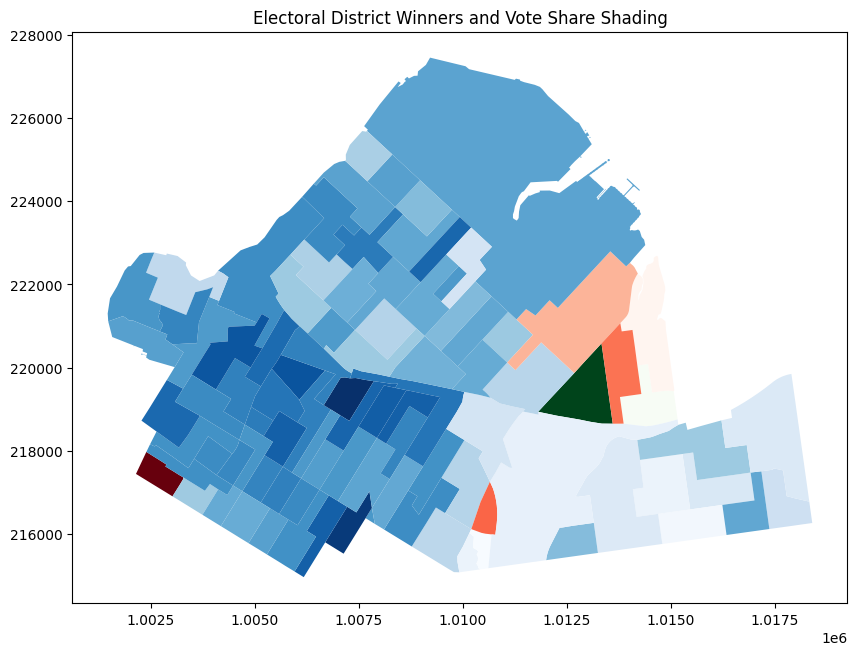

In [17]:
winners = gpd.GeoDataFrame(winners,geometry=winners['geometry'].apply(wkt.loads))

fig, ax = plt.subplots(1, figsize=(10, 10))
winners.plot(color=winners['color'], ax=ax)
ax.set_title("Electoral District Winners and Vote Share Shading")
plt.show()

In [9]:
d22.groupby('district_22_choice_1')['district_22_choice_2'].value_counts(dropna=False).unstack().fillna(0)

district_22_choice_2,Catherina Gioino,Evie Hantzopoulos,John J. Ciafone,Leonardo T. Bullaro,Nick Velkov,Tiffany Caban,Write-in,overvote,NaN
district_22_choice_1,,,,,,,,,
Catherina Gioino,3.0,108.0,96.0,75.0,51.0,256.0,0.0,3.0,200.0
Evie Hantzopoulos,363.0,20.0,311.0,502.0,176.0,1936.0,4.0,2.0,852.0
John J. Ciafone,173.0,359.0,19.0,251.0,67.0,175.0,4.0,1.0,559.0
Leonardo T. Bullaro,117.0,292.0,213.0,7.0,41.0,232.0,0.0,0.0,312.0
Nick Velkov,77.0,92.0,40.0,21.0,5.0,106.0,0.0,1.0,118.0
Tiffany Caban,739.0,3889.0,451.0,463.0,266.0,34.0,15.0,3.0,2062.0
Write-in,1.0,2.0,5.0,3.0,0.0,2.0,0.0,0.0,17.0
overvote,4.0,5.0,1.0,2.0,2.0,1.0,0.0,2.0,15.0


In [20]:
ag = d22.groupby(['Precinct','district_22'+'_choice_1'])['district_22'+'_choice_2'].value_counts(dropna=False).reset_index(name='count')

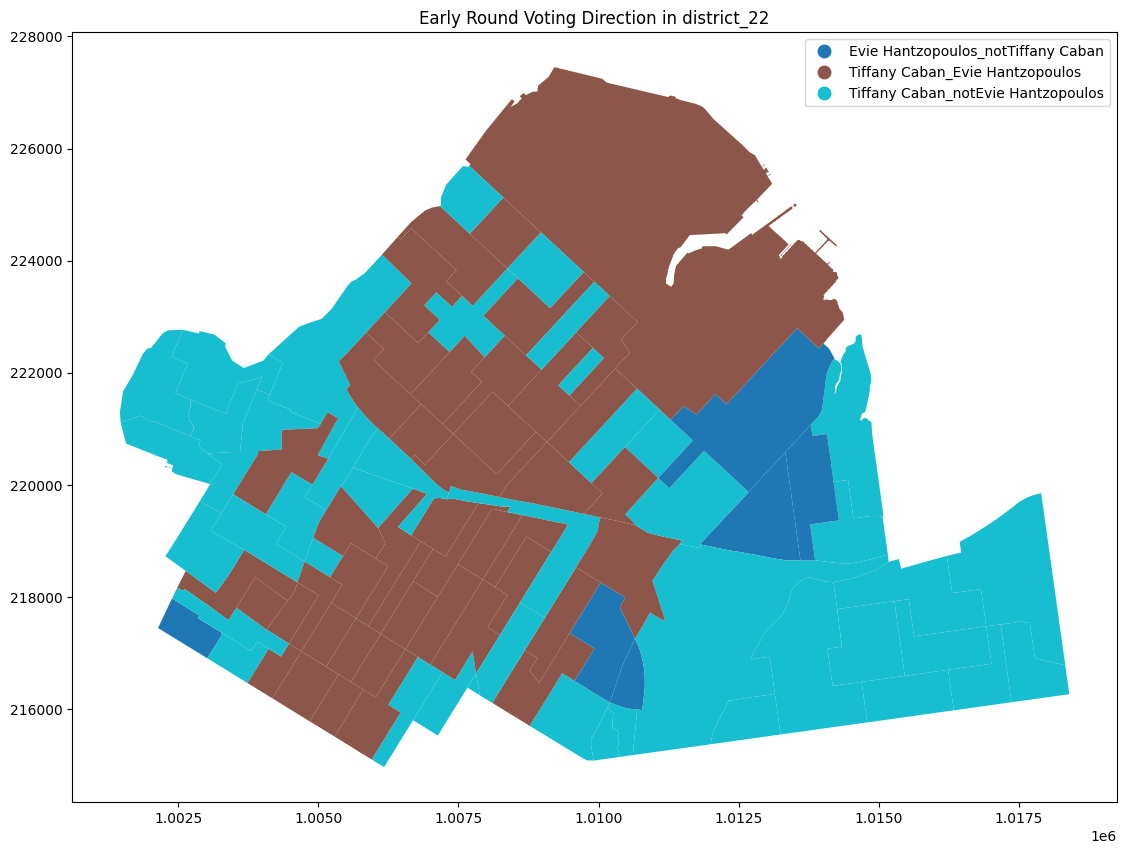

In [23]:
map_round_votes(d22,ed_gdf,'district_22','Tiffany Caban','Evie Hantzopoulos')

Clustering

In [15]:
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')
to_remove = [ 'w2psp',
 'w2sep',
 'w2npp',
 'w2govp',
 'w2nip']
wp_cols = [col for col in wp_cols if col not in to_remove]
demo_cols = ['nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21']
cluster_cols = wp_cols + demo_cols

In [8]:
demo_occ = winner_twenty_two[['ed_name','nhw21p','nhb21p','h21p','nha21p','cvap21bapp','mhhi21','venez21p','chin21p',
                 'kor21p','colomb21p','domin21p','mex21p','white_transplant_ratio']].merge(occ_df, left_on='ed_name', right_on='ElectDist', how='left')

In [20]:
df_cluster = demo_occ[cluster_cols]

In [31]:
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

Text(0.5, 1.0, 'Elbow Method')

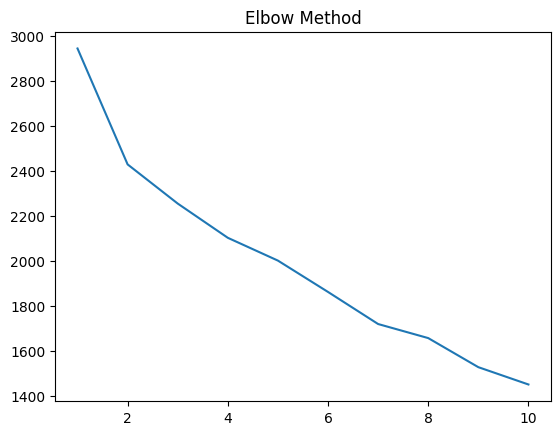

In [32]:
# elbow method to determine number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_cluster_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')

In [47]:
kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(df_cluster_scaled)
demo_occ['cluster'] = kmeans.labels_

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [24]:
ae.head()

,ElectDist,Shape_Leng,Shape_Area,geometry,ind21p,bang21p,chin21p,filip21p,kor21p,nep21p,pak21p,sril21p,taiw21p,thai21p,viet21p
0,23001,25826.498431,2.613472e+07,POLYGON ((1007309.8452148438 141975.6732177734...,6.314231e-03,0.0,0.000000,0.000000,1.136562e-01,0.0,0.000000e+00,0.0,0.0,0.0,0.006314
1,23002,13932.130458,5.637463e+06,MULTIPOLYGON (((1006386.2789916992 144120.6552...,2.644104e-02,0.0,0.000000,0.000000,4.759387e-01,0.0,0.000000e+00,0.0,0.0,0.0,0.026441
2,23006,8261.763819,3.188046e+06,POLYGON ((1025021.7086181641 147481.0651855468...,0.000000e+00,0.0,1.441020,0.496179,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.0,0.000000
3,23008,9028.976073,2.914810e+06,POLYGON ((1026756.3640136719 147970.5953979492...,6.508830e-09,0.0,2.038217,0.738854,1.446407e-08,0.0,1.157125e-08,0.0,0.0,0.0,0.000000
4,23009,8989.997452,2.779038e+06,POLYGON ((1027647.7304077148 148397.8187866211...,2.198339e-01,0.0,0.561798,0.415242,4.885197e-01,0.0,3.908158e-01,0.0,0.0,0.0,0.000000


In [9]:
demo_occ = demo_occ.merge(ae[['ElectDist','ind21p','bang21p','pak21p','filip21p']],left_on='ElectDist',right_on='ElectDist',how='left')

In [10]:
demo_occ_map = gpd.GeoDataFrame(demo_occ,geometry=demo_occ['geometry'].apply(wkt.loads))

In [ ]:
demo_occ.groupby('cluster')[demo_cols].mean()

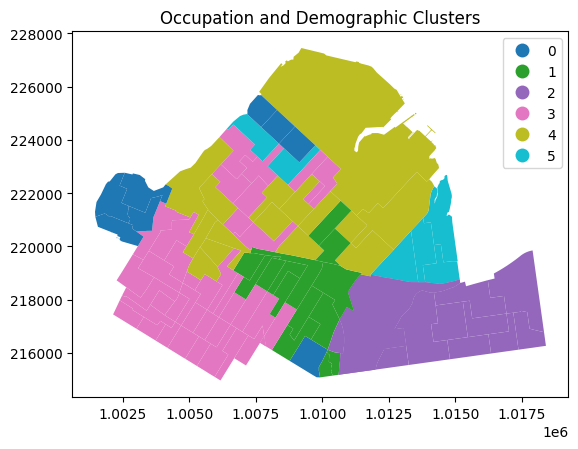

In [49]:
demo_occ_map['cluster'] = demo_occ_map['cluster'].astype('category')
demo_occ_map.plot(column='cluster',legend=True)
plt.title("Occupation and Demographic Clusters")
plt.show()

In [11]:
demo_occ[['ed_name','nhw21p','cvap21bapp','mhhi21','kor21p','ind21p','bang21p','chin21p','colomb21p','w2mgtp',
 'w2banp',
 'w2cmp',
 'w2aep',
 'w2scip',
 'w2cossp',
 'w2lawp',
 'w2edup',
 'w2admp',
 'white_transplant_ratio']].sample(10)

,ed_name,nhw21p,cvap21bapp,mhhi21,kor21p,ind21p,bang21p,chin21p,colomb21p,w2mgtp,w2banp,w2cmp,w2aep,w2scip,w2cossp,w2lawp,w2edup,w2admp,white_transplant_ratio
32,36017,52.647585,70.304325,38913.314741,0.853245,4.961285,2.843025e+00,9.721598,2.099106,13.506534,7.965600,6.499427,1.758856,0.990650,2.181107,1.410581,7.477348,10.695677,14.892829
71,36058,66.293117,55.861799,61387.925333,1.863834,0.531831,1.012313e+00,2.496964,2.817354,18.531369,11.365132,3.683496,1.094555,2.682025,1.445177,1.291987,6.474280,10.360428,17.396568
12,34042,12.492841,23.370494,32390.773803,0.000000,21.157202,1.013830e-01,6.341517,2.959456,13.301368,4.571830,0.100744,0.007029,0.694560,1.012625,0.030457,1.585639,4.782690,2.032388
84,36077,53.008905,70.823180,36309.354398,2.303486,6.056792,1.744543e+00,3.289014,1.562184,11.028917,9.332666,7.778715,2.799842,0.597002,2.446842,2.447693,9.135822,13.619813,23.463147
8,34011,19.163830,31.669926,31593.375535,0.498007,8.822706,2.199924e+00,6.104855,14.255245,8.922963,3.060563,3.488197,2.435722,1.305384,3.681898,0.682444,12.657303,2.723438,1.375643
41,36027,60.835657,54.744785,55987.796522,1.533770,1.336492,2.280387e-01,3.896817,2.225550,15.580802,5.662015,2.464609,2.166777,1.880290,1.090729,2.439459,10.146258,3.501035,11.235828
66,36053,73.829789,51.109573,49272.376743,1.329787,1.062190,2.177326e-08,0.585107,3.138298,14.199619,15.519123,9.216995,1.406280,1.878044,2.291655,2.715840,6.504579,6.342558,10.053192
16,36001,67.408585,44.457641,18287.657292,2.098569,1.081081,0.000000e+00,3.593005,3.211447,15.591398,14.669739,6.374808,0.614439,0.537634,0.460829,2.150538,11.674347,0.691244,10.651828
63,36050,31.787267,32.728868,56199.138362,0.201767,2.129876,1.205580e+00,7.540265,2.162221,2.999059,1.681875,1.404652,0.227093,0.348537,0.718602,0.896954,1.832470,3.271369,3.123941
70,36057,62.670057,54.872238,47951.262093,1.418260,0.792362,1.672949e+00,2.524569,3.637419,17.719822,12.610121,3.656588,0.554697,2.321933,1.539837,1.296847,8.173094,10.326892,15.959946


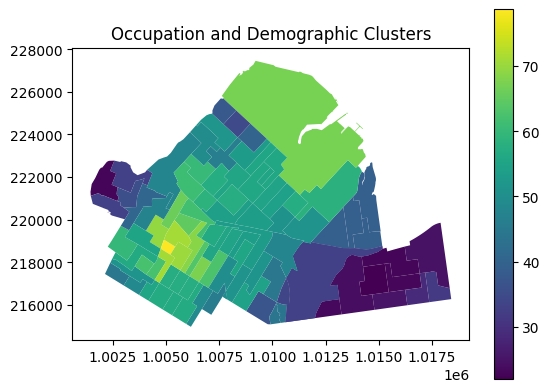

In [42]:
demo_occ_map.plot(column='cvap21bapp',legend=True)
plt.title("Occupation and Demographic Clusters")
plt.show()

In [12]:
gdf = demo_occ_map.copy()

In [13]:
eth_cols = ['ind21p','bang21p','chin21p','colomb21p','mex21p','white_transplant_ratio']
red_eth_cols = ['nhw21p','nhb21p','h21p','nha21p']

In [34]:
gdf[eth_cols].describe()

,ind21p,bang21p,chin21p,colomb21p,mex21p,white_transplant_ratio
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,3.818585,1.404666,3.838968,3.424922,5.242352,11.642818
std,3.555168,1.394208,3.294339,2.831430,3.661032,5.716381
min,0.054182,0.000000,0.136457,0.223258,0.000000,0.624466
25%,1.242660,0.246009,1.728041,2.053119,2.456605,7.538720
50%,2.779074,1.205580,2.818845,2.817354,4.663695,12.884664
75%,5.236169,1.850790,5.273228,3.782116,7.346531,15.674096
max,21.157202,9.040509,16.971583,14.718026,16.259740,23.614707


In [16]:
gdf['dom_eth']   = gdf[eth_cols].idxmax(axis=1)  
gdf['dom_eth_p'] = gdf[eth_cols].max(axis=1)      

gdf['dom_occ']   = gdf[wp_cols].idxmax(axis=1)
gdf['dom_occ_p'] = gdf[wp_cols].max(axis=1)

In [167]:
def make_distinct_colormap(categories, palette_name='tab20'):
    """
    Returns dict mapping each category to a hex color, 
    drawn from Matplotlib’s qualitative palette.
    """
    n = len(categories)
    # grab n distinct colors from the palette
    palette = plt.get_cmap(palette_name).colors
    if n > len(palette):
        raise ValueError(f"Palette {palette_name} only has {len(palette)} colors")
    colors = palette[:n]
    return dict(zip(categories, (to_hex(c) for c in colors)))

eth_colors = make_distinct_colormap(sorted(gdf['dom_eth'].unique()), 'tab20')
occ_colors = make_distinct_colormap(sorted(gdf['dom_occ'].unique()), 'tab20')

# 2) map them into new columns on your GeoDataFrame
gdf['eth_color'] = gdf['dom_eth'].map(eth_colors)
gdf['occ_color'] = gdf['dom_occ'].map(occ_colors)

def pct_to_color(hue, pct):
    """
    Convert hue [0–1] & pct [0–100] to an RGB hex.
    We fix saturation=0.7 and vary value/lightness between 0.4 and 1.
    """
    sat = 0.7
    # map 0–100 → 0.4–1.0
    val = 0.4 + 0.6*(pct/100)
    r, g, b = colorsys.hsv_to_rgb(hue, sat, val)
    return (r, g, b)

In [ ]:
gdf = gdf.set_crs(epsg=2263, allow_override=True)
gdf_3857 = gdf.to_crs(epsg=3857)

In [169]:
gdf_3857 = gdf.to_crs(epsg=3857)

In [ ]:
occ_label_map = {
    'w2admp': 'Designers & Journalists',
    'w2banp': 'Analyst Specialist',
    'w2bgp': 'Janitorial',
    'w2conp': 'Construction',
    'w2copp': 'Law Enforcement',
    'w2foodp': 'Food Service',
    'w2hsp': 'Homecare',
    'w2mgtp': 'Management',
    'w2oadp': 'Office Admin',
    'w2salep': 'Sales'
}

gdf_3857['occupation_label'] = gdf_3857['dom_occ'].map(occ_label_map)
gdf_3857['occupation_label'] = gdf_3857['occupation_label'].astype('category')

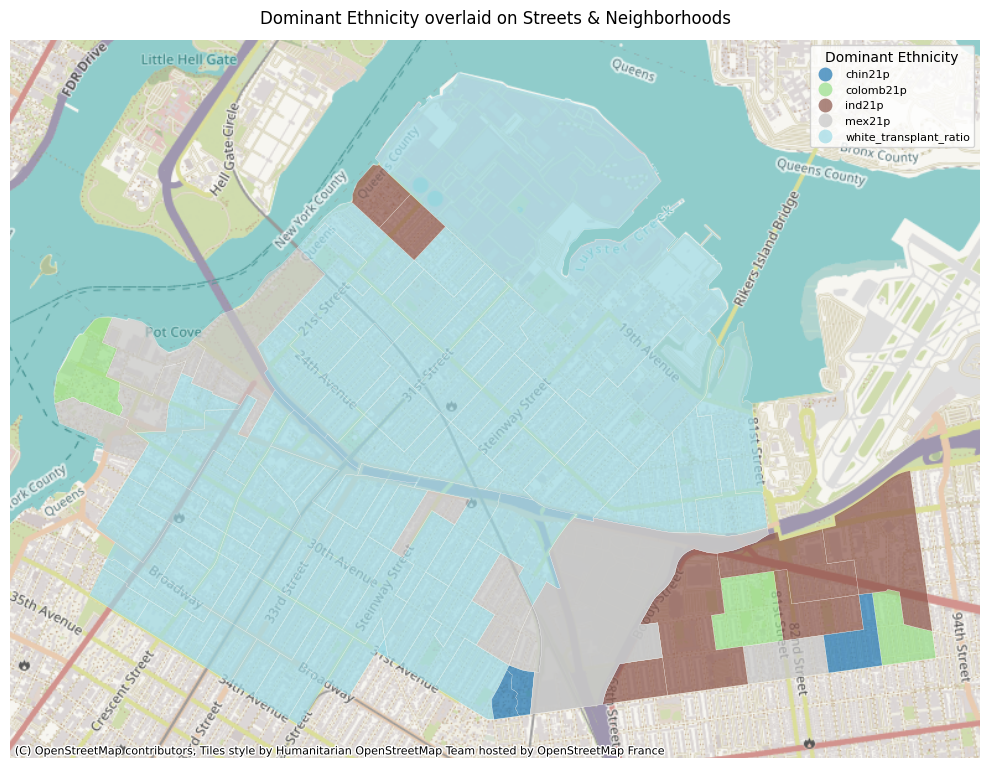

In [170]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_3857.plot(
    column='dom_eth',
    categorical=True,
    cmap='tab20',
    legend=True,
    alpha=0.7,
    ax=ax,
    edgecolor='white',
    linewidth=0.2,
    legend_kwds={'title': 'Dominant Ethnicity', 'fontsize': 8, 'title_fontsize': 10}
)

# 4) Add the basemap tiles
#    You can pick any provider; here are some popular ones:
#      - ctx.providers.OpenStreetMap.Mapnik
#      - ctx.providers.Stamen.TonerLite
#      - ctx.providers.CartoDB.Positron
#      - ctx.providers.Stamen.Terrain
ctx.add_basemap(
    ax,
    #source=ctx.providers.CartoDB.Positron,  
    zoom=14   
)

# 5) Clean up
ax.set_axis_off()
ax.set_title("Dominant Ethnicity overlaid on Streets & Neighborhoods", pad=12)

plt.tight_layout()
plt.show()


In [36]:
do_vote = demo_occ.merge(tc_full[['ed_name','vote_share']], on='ed_name', how='left')

In [37]:
cor_cols = ['nhw21p','mex21p','mhhi21','kor21p','ind21p','bang21p','chin21p','colomb21p'] 
cor_matrix = do_vote[cor_cols].corr()
cor_matrix.sort_values(by='mex21p', ascending=False)

,nhw21p,mex21p,mhhi21,kor21p,ind21p,bang21p,chin21p,colomb21p
mex21p,-0.430614,1.000000,0.124908,-0.061405,0.117482,0.119253,0.039901,0.184542
colomb21p,-0.632693,0.184542,-0.126299,-0.161495,0.508571,0.321055,0.318433,1.000000
mhhi21,0.116923,0.124908,1.000000,0.175838,-0.045220,-0.211496,-0.074983,-0.126299
bang21p,-0.375191,0.119253,-0.211496,-0.014179,0.278301,1.000000,0.405479,0.321055
ind21p,-0.698357,0.117482,-0.045220,0.053111,1.000000,0.278301,0.303057,0.508571
chin21p,-0.434702,0.039901,-0.074983,-0.141869,0.303057,0.405479,1.000000,0.318433
kor21p,0.075861,-0.061405,0.175838,1.000000,0.053111,-0.014179,-0.141869,-0.161495
nhw21p,1.000000,-0.430614,0.116923,0.075861,-0.698357,-0.375191,-0.434702,-0.632693


In [38]:
cat_demo = do_vote.merge(pc[['ed_name','biggest']],on='ed_name', how='left')

NameError: name 'pc' is not defined

In [43]:
cat_demo.groupby('biggest')[['mhhi21','nhw21p','cvap21bapp','w2admp','w2cmp','w2conp','w2lawp']].mean().reset_index()

,biggest,mhhi21,nhw21p,cvap21bapp,w2admp,w2cmp,w2conp,w2lawp
0,Evie Hantzopoulos_notTiffany Caban,28893.062462,59.704889,43.210761,4.617295,3.861488,11.381614,4.120871
1,Tiffany Caban_Evie Hantzopoulos,44406.833495,57.751150,57.038422,9.534899,5.285399,6.144240,2.191993
2,Tiffany Caban_notEvie Hantzopoulos,36905.061407,43.642122,43.487982,5.664533,4.518637,10.023939,2.083966


In [39]:
do_vote['log_mhhi21'] = np.log(do_vote['mhhi21'])

In [37]:
target = do_vote['tc_vote_share']
mod1 = sm.OLS(target, sm.add_constant(do_vote[['log_mhhi21','cvap21bapp']])).fit()
mod2 = sm.OLS(target, sm.add_constant(do_vote[['log_mhhi21','cvap21bapp','w2admp','w2conp','w2lawp','w2tranp']])).fit()
mod3 = sm.OLS(target, sm.add_constant(do_vote[['log_mhhi21','cvap21bapp','kor21p','ind21p','bang21p','chin21p','colomb21p']])).fit()
mod4 = sm.OLS(target, sm.add_constant(do_vote[['log_mhhi21','cvap21bapp','kor21p','ind21p','bang21p','chin21p','colomb21p','w2admp','w2conp','w2lawp','w2tranp']])).fit()

In [38]:
summary_col([mod1,mod2,mod3,mod4], stars=True)

,tc_vote_share I,tc_vote_share II,tc_vote_share III,tc_vote_share IIII
const,5.7055,31.1753**,5.1835,29.7783**
,(14.9899),(14.1825),(15.7056),(14.2608)
log_mhhi21,1.5762,0.5946,1.0957,0.5873
,(1.4708),(1.2918),(1.5323),(1.3305)
cvap21bapp,0.4621***,0.1948,0.5237***,0.1965
,(0.0765),(0.1217),(0.0965),(0.1234)
w2admp,,0.8017**,,0.8730**
,,(0.3261),,(0.3387)
w2conp,,-0.6638***,,-0.8241***
,,(0.2050),,(0.2355)


In [17]:
colnames = ['a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'j',
       'k', 
        'AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

good_cols = ['AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

def read_noncc_votes(filepath,colnames,good_cols):
    df = pd.read_csv(filepath,header=None, names=colnames)
    df = df[good_cols]
    df['precinct'] = 'AD: ' + df['AD'].astype(str) + ' ' + 'ED: ' + df['ED'].astype(str).str.zfill(3)
    df['ed_name'] = df['AD'].astype(str) + df['ED'].astype(str).str.zfill(3)
    return df
def make_vote_share(df,candidates):
    df_cand = df[df['Unit Name'].isin(candidates)]
    df_cand = df_cand[['precinct','ed_name','Unit Name','Tally']]
    df_cand.columns = ['precinct','ed_name','candidate','votes']
    df_cand['ed_total'] = df_cand.groupby('ed_name')['votes'].transform('sum')
    df_cand['vote_share'] = round(df_cand['votes'] / df_cand['ed_total'] * 100,2)
    df_cand['vote_share'] = pd.to_numeric(df_cand['vote_share'], errors='coerce')
    df_cand.dropna(inplace=True)
    return df_cand

In [145]:
filepath = '../data/aoc_raw.csv'
candidates = ['Alexandria Ocasio-Cortez','Joseph Crowley']
noncc = read_noncc_votes(filepath,colnames,good_cols)
mvs = make_vote_share(noncc,candidates)

In [147]:
aoc_clean = mvs[mvs['candidate'] == 'Alexandria Ocasio-Cortez']

In [149]:
aoc_clean.columns = ['precinct','ed_name','candidate','aoc_votes','ed_total','aoc_vote_share']

In [29]:
do_vote.rename(columns={'vote_share':'tc_vote_share'},inplace=True)

In [154]:
aoc_clean['ed_name'] = aoc_clean['ed_name'].astype('Int64')

C:\Users\samtg\AppData\Local\Temp\ipykernel_13212\3275283636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aoc_clean['ed_name'] = aoc_clean['ed_name'].astype('Int64')


In [155]:
do_vote = do_vote.merge(aoc_clean[['ed_name','aoc_vote_share']], on='ed_name', how='left')

In [157]:
do_vote['aoc_vote_share_standardized'] = (do_vote['aoc_vote_share'] - do_vote['aoc_vote_share'].mean()) / do_vote['aoc_vote_share'].std()
do_vote['tc_vote_share_standardized'] = (do_vote['tc_vote_share'] - do_vote['tc_vote_share'].mean()) / do_vote['tc_vote_share'].std()
do_vote['vote_diff'] = do_vote['aoc_vote_share_standardized'] - do_vote['tc_vote_share_standardized']

In [159]:
do_vote.dropna(subset=['vote_diff'],inplace=True)

In [161]:
do_vote_map = gpd.GeoDataFrame(do_vote,geometry=do_vote['geometry'].apply(wkt.loads))

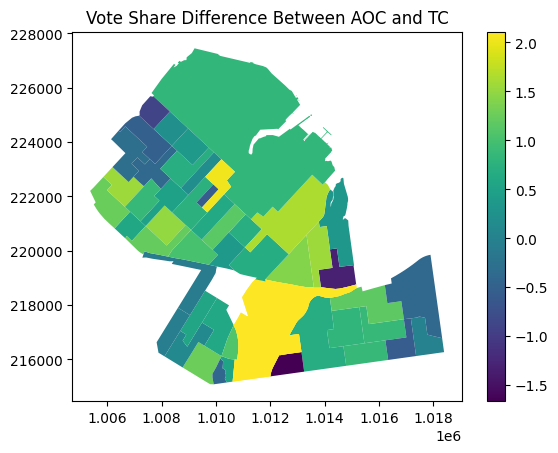

In [162]:
do_vote_map.plot(column='vote_diff',legend=True)
plt.title("Vote Share Difference Between AOC and TC")
plt.show()

DA results

In [18]:
da_race = pd.read_excel('../data/unoff_queens_da_results.xlsx',sheet_name='BOEunofficial_QDA2019_reformat')

In [19]:
da_race['tc_share'] = (da_race['Caban'] / da_race['Total'] * 100).round(2) 
da_race.rename(columns={'ADED':'ed_name'},inplace=True)
da_race = da_race[['ed_name','tc_share']]

In [20]:
cc_da = tc_full.merge(da_race, on='ed_name', how='left')

In [ ]:
from sklearn.preprocessing import StandardScaler

In [25]:
#scale vote_share and tc_share as new columns
cc_da['da_standardized'] = (cc_da['tc_share'] - cc_da['tc_share'].mean()) / cc_da['tc_share'].std()
cc_da['cc_standardized'] = (cc_da['vote_share'] - cc_da['vote_share'].mean()) / cc_da['vote_share'].std()
cc_da['vote_diff'] =  cc_da['cc_standardized'] - cc_da['da_standardized']
cc_da.dropna(subset=['vote_diff'],inplace=True)

In [20]:
cc_da[['da_standardized','tc_share','cc_standardized','vote_share','vote_diff']].sort_values(by='vote_diff',ascending=False).head(10)

,da_standardized,tc_share,cc_standardized,vote_share,vote_diff
55,-0.317600,63.89,-2.100526,21.951220,1.782926
47,0.700605,80.00,-0.742065,37.037037,1.442670
38,1.352862,90.32,0.195519,47.448980,1.157343
50,0.435783,75.81,-0.644852,38.116592,1.080635
15,-0.485088,61.24,-1.474026,28.908555,0.988937
17,1.046958,85.48,0.098972,46.376812,0.947987
45,0.500250,76.83,-0.436935,40.425532,0.937185
5,-1.037485,52.50,-1.945617,23.671498,0.908132
59,-1.052022,52.27,-1.958412,23.529412,0.906390
49,0.415558,75.49,-0.457597,40.196078,0.873155


In [22]:
cc_da = cc_da.merge(occ_df,left_on = 'ed_name',right_on = 'ElectDist',how='left')
cc_da = cc_da.merge(ae[['ElectDist','ind21p','bang21p','pak21p','filip21p']],on = 'ElectDist',how='left')
cc_da = cc_da.merge(av,on='ElectDist',how='left')

In [23]:
cc_da['native_whites'] = cc_da['nhw21p'] - cc_da['white_transplant_ratio']

In [32]:
cc_da['w2admp']

0      1.819080
1      3.934242
2     11.438260
3     12.341602
4      3.938434
        ...    
86     2.556818
87     1.939285
88     5.052717
89     2.490594
90     3.372240
Name: w2admp, Length: 91, dtype: float64

In [68]:
pd.set_option('display.max_columns', None)

In [69]:
cc_da.head()

,Precinct,vote,total_vote_precinct,vote_share,ed_name,winner,rank,district,candidate,matched_name,kmode_cluster,member,ElectDist_x,ML4,ML6,ML5,ML2,ML7,ML3,ML1,district_cluster,ElectDist_y,Shape_Leng_x,Shape_Area_x,geometry_x,min_noise,max_noise,summer_noise_complaints,min_arrests,max_arrests,density,ldensity,p21own,p21rent,mhhi21,mean_noise,mean_arrests,living_alone_ratio,same_sex_ratio,black_nys_ratio,black_fb_ratio,white_transplant_ratio,femHHH_ratio,drive_ratio,train_ratio,walk_ratio,bike_ratio,wfh_ratio,bus_ratio,hh21olongp,h21p,nha21p,nhb21p,nhw21p,mex21p,prican21p,domin21p,colomb21p,kor21p,chin21p,venez21p,hh21op,hh21rc,range_of_arrests,range_of_noise,cvap21bapp,rv21irp,rv21italp,pg20jrbp,pg20djtp,dpp20bs,adams213p,garcia213p,winda21p,perc_retail,perc_finance,perc_healthcare,tc_share,da_standardized,cc_standardized,vote_diff,ElectDist,Shape_Leng_y,Shape_Area_y,geometry_y,w2,wm2,wm2mgt,w2mgt,wm2bizfin,w2ban,wm2cm,w2cm,wm2ae,w2ae,wm2lps,w2sci,wm2coss,w2coss,wm2legal,w2law,wm2educ,w2edu,wm2adesm,w2adm,wm2doc,w2doc,wm2ht,w2ht,wm2hs,w2hs,wm2ff,w2ff,wm2food,w2food,wm2bgcm,w2bg,wm2pcare,w2pserve,wm2sales,w2sale,wm2office,w2oad,wm2farm,w2farm,wm2cons,w2cons,wm2imr,w2emr,wm2prod,w2prod,wm2trans,w2trans,wm2mat,w2mat,wf2,wf2mgt,wf2bizfin,wf2cm,wf2ae,wf2lps,wf2coss,wf2legal,wf2educ,wf2adesm,wf2hpto,wf2doc,wf2ht,wf2hs,wf2ff,wf2food,wf2bgcm,wf2pcare,wf2sales,wf2office,wf2farm,wf2cons,wf2imr,wf2prod,wf2trans,wf2mat,wm2ag,wm2min,wm2con,wm2mfg,wm2whole,wm2retail,wm2tw,wm2util,wm2info,wm2fin,wm2re,wm2profsci,wm2cmgt,wm2admin,wm2ed,wm2hcss,wm2arts,wm2acfood,wm2osvc,wm2pubad,wf2ag,wf2min,wf2con,wf2mfg,wf2whole,wf2retail,wf2tw,wf2util,wf2info,wf2fin,wf2re,wf2profsci,wf2cmgt,wf2admin,wf2ed,wf2hcss,wf2arts,wf2acfppd,wf2osvc,wf2pubad,w2mgr,w2service,w2sales,w2conmaint,w2prodtran,wps2,wps2mgr,wps2service,wps2sales,wps2conmaint,wps2prodtran,wse2,wse2mgr,wse2service,wse2sales,wse2conmaint,wse2prodtran,wnp2,wnp2mgr,wnp2service,wnp2sales,wnp2conmaint,wnp2prodtran,wg2,wg2mgr,wg2service,wg2sales,wg2contmaint,wg2progtran,wni2,wni2mgr,wni2service,wni2sales,wni2conmaint,wni2prodtran,pg24,pg24turn,kdh24,djt24,wfp24,con24,pg2420,pg2420d,pg2420r,djtpch,rv25,filter_$,w2mgtp,w2banp,w2cmp,w2aep,w2scip,w2cossp,w2lawp,w2edup,w2admp,w2docp,w2htp,w2hsp,w2ffp,wm2cop,w2cop,w2copp,w2foodp,w2bgp,w2pservep,w2salep,w2oadp,w2farmp,w2conp,w2emrp,w2prodp,w2tranp,w2matp,wf2cop,w2psp,w2sep,w2npp,w2govp,w2nip,kdh24p,djt24p,wfp24p,con24p,ind21p,bang21p,pak21p,filip21p,Shape_Leng,Shape_Area,geometry,p21fb,fb21el,greek21p,arab21p,fb21bdp,fb21drp,hh21bop,native_whites,log_mhhi21
0,AD: 30 ED: 060,71.0,197.0,36.040609,30060,True,1.0,22,Tiffany Caban,Tiffany Caban,3.0,tiffany cabán,30060.0,0.223721,0.683939,-0.293914,1.126567,-0.007873,-0.274709,-0.231150,3.0,30060.0,4537.862119,1.190418e+06,POLYGON ((1009572.5504150391 216502.8541870117...,1.437923,25.017214,57.972415,0.662525,4.295712,33526.511299,7.172191,365.325861,1730.524500,37645.525295,18.766574,2.690293,5.641112,0.383489,11.051344,0.407970,6.081319,16.809389,13.561104,1.007477,16.066509,0.006054,6.898650,3.923341,64.951274,40.539043,8.795265,10.873204,37.688109,2.021455,12.472660,9.385165,2.201636,0.935741,5.500763,0.455256,14.900361,46.409364,6.559908,36.415575,36.850825,2.604920,1.888556,76.560171,21.274464,108.574558,35.215113,45.382944,0.096190,10.171876,7.250950,16.900927,66.67,-0.141895,-0.831792,0.689897,30060,4537.862119,1.190418e+06,POLYGON ((1009572.5504150391 216502.8541870117...,1030.367859,506.813120,50.693448,116.167193,18.930453,65.481448,5.413011,22.087426,9.670328,13.731979,17.644424,20.909995,5.970606e+00,13.249290,13.107420,30.178480,19.665480,92.139939,13.393731,24.067771,16.281349,30.579491,3.283625,18.409160,0.0,35.823251,20.458249,20.584634,52.860385,86.574103,0.234718,32.955277,23.658625,40.654630,17.734404,44.314872,15.140221,94.940494,0.0,0.0,55.951253,58.761277,14.398333,14.398334,12.592022,32.247420,64.213828,64.213829,55.517207,57.897566,523.554739,65.473745,46.550994,16.674415,4.061651,3.265571

In [24]:
cor_cols = cc_da[['vote_diff','vote_share','tc_share','nhw21p','cvap21bapp','mhhi21','white_transplant_ratio','ind21p','colomb21p','mex21p',
                  'w2lawp','native_whites','greek21p','arab21p','w2admp','nha21p','h21p','w2cmp']].columns.tolist()
cor_cols = cc_da.drop(columns=['ElectDist','geometry','Precinct','ed_name','candidate','matched_name','member','geometry_x','geometry_y']).columns.tolist()
cor_matrix = cc_da[cor_cols].corr()
cor_matrix.dropna(subset=('vote_share'),inplace=True)
cor_matrix.sort_values(by='vote_share', ascending=False).head(50)

,vote,total_vote_precinct,vote_share,winner,rank,district,kmode_cluster,ElectDist_x,ML4,ML6,...,Shape_Leng,Shape_Area,p21fb,fb21el,greek21p,arab21p,fb21bdp,fb21drp,hh21bop,native_whites
vote_share,0.766745,0.402358,1.000000,0.654572,-0.665876,NaN,NaN,0.193540,0.607221,0.077961,...,-0.140300,-0.134103,-0.070975,0.018067,-0.061609,0.245038,-0.022504,-0.231816,-0.362452,-0.032610
cc_standardized,0.766745,0.402358,1.000000,0.654572,-0.665876,NaN,NaN,0.193540,0.607221,0.077961,...,-0.140300,-0.134103,-0.070975,0.018067,-0.061609,0.245038,-0.022504,-0.231816,-0.362452,-0.032610
vote,1.000000,0.869299,0.766745,0.433797,-0.489301,NaN,NaN,0.292293,0.726004,-0.168149,...,-0.134313,-0.105588,-0.124107,0.176233,0.107346,0.209117,-0.113303,-0.321760,-0.367048,0.187985
pg20jrbp,0.593453,0.400408,0.699159,0.630630,-0.607774,NaN,NaN,0.062717,0.441853,0.352182,...,-0.354588,-0.313209,0.007273,-0.248423,-0.262610,0.276336,0.181343,-0.102194,-0.202223,-0.423612
wfp24p,0.718630,0.610050,0.656873,0.371317,-0.380282,NaN,NaN,0.141774,0.853887,-0.178578,...,-0.470597,-0.431353,-0.224358,0.084318,0.196274,0.292819,-0.108408,-0.432011,-0.339464,0.215581
winner,0.433797,0.169644,0.654572,1.000000,-0.920861,NaN,NaN,0.224068,0.308973,0.272182,...,-0.008103,-0.003416,0.303946,0.076889,-0.041479,0.110642,0.085483,-0.145236,-0.173170,-0.223568
da_standardized,0.677208,0.522150,0.653945,0.433457,-0.431153,NaN,NaN,0.124055,0.770187,-0.204948,...,-0.124874,-0.090422,-0.093272,0.294956,0.246656,0.278735,-0.121149,-0.538749,-0.312071,0.301737
tc_share,0.677208,0.522150,0.653945,0.433457,-0.431153,NaN,NaN,0.124055,0.770187,-0.204948,...,-0.124874,-0.090422,-0.093272,0.294956,0.246656,0.278735,-0.121149,-0.538749,-0.312071,0.301737
wfp24,0.749443,0.624732,0.642087,0.468013,-0.478127,NaN,NaN,0.274950,0.751040,-0.141070,...,-0.052410,-0.091699,0.145812,0.324859,0.133246,0.259467,-0.154147,-0.343485,-0.367273,0.201194
ML4,0.726004,0.653522,0.607221,0.308973,-0.348285,NaN,NaN,0.291287,1.000000,-0.488599,...,-0.180272,-0.133817,-0.326189,0.334031,0.348909,0.198567,-0.343008,-0.497076,-0.450452,0.498245


In [58]:
cc_da.columns

Index(['Precinct', 'vote', 'total_vote_precinct', 'vote_share', 'ed_name',
       'winner', 'rank', 'district', 'candidate', 'matched_name',
       ...
       'Shape_Area', 'geometry', 'p21fb', 'fb21el', 'greek21p', 'arab21p',
       'fb21bdp', 'fb21drp', 'hh21bop', 'native_whites'],
      dtype='object', length=300)

In [74]:
cc_da.to_csv('../data/cc_da_results_master.csv',index=False)

In [26]:
label_map = {
    'vote_diff': 'Vote Difference (CC - DA)',
    'vote_share': 'Caban Vote Share',
    'nhw21p': 'Non-Hispanic White',
    'h21p': 'Hispanic',
    'cvap21bapp': 'BA+',
    'white_transplant_ratio': 'White Transplant Ratio',
    'native_whites': 'Whites Born in NYS',
    'hh21op': 'Homeowners',
    'drive_ratio': 'Car Commuters',
    'w2conp': 'Construction Workers',
    'w2admp': 'Designers & Journalists',
    'w2govp': 'Government Workers',
    'greek21p': 'Greek Share'
}

In [29]:
small_cor_cols = ['vote_share','vote_diff','nhw21p','h21p','cvap21bapp','white_transplant_ratio','greek21p','hh21op','drive_ratio']
small_cor_matrix = cc_da[small_cor_cols].corr()
small_cor_matrix.dropna(subset=('vote_share'),inplace=True) 
small_cor_matrix.rename(index=label_map, columns=label_map, inplace=True)

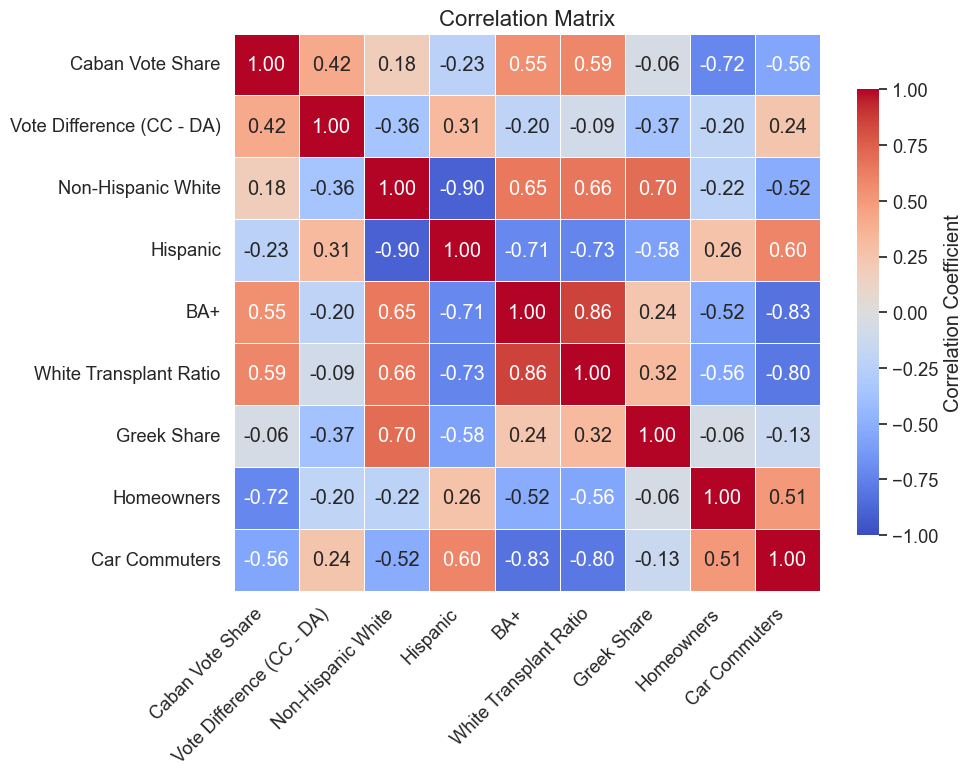

In [30]:
plt.figure(figsize=(10, 8))
sns.set(style="white", font_scale=1.2)

heatmap = sns.heatmap(
    small_cor_matrix,
    annot=True,             
    fmt=".2f",             
    cmap="coolwarm",        
    vmin=-1, vmax=1,        
    linewidths=0.5,         
    cbar_kws={"shrink": 0.8, 'label': 'Correlation Coefficient'}
)

plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [77]:
cc_da['log_mhhi21'] = np.log(cc_da['mhhi21'])

In [43]:
target = cc_da['vote_share']
mod1 = sm.OLS(target,sm.add_constant(cc_da[['log_mhhi21','cvap21bapp']])).fit()
mod2 = sm.OLS(target,sm.add_constant(cc_da[['log_mhhi21','cvap21bapp','white_transplant_ratio','greek21p','arab21p']])).fit()
mod3 = sm.OLS(target,sm.add_constant(cc_da[['log_mhhi21','cvap21bapp','white_transplant_ratio','greek21p','arab21p','w2cmp','w2admp','w2hsp','w2mgtp']])).fit()
mod4 = sm.OLS(target,sm.add_constant(cc_da[['log_mhhi21','greek21p','arab21p','w2cmp','w2admp','w2hsp','w2mgtp']])).fit()
mod5 = sm.OLS(target,sm.add_constant(cc_da[['log_mhhi21','cvap21bapp','white_transplant_ratio','greek21p','arab21p','w2cmp','w2admp','w2hsp','w2mgtp','w2bgp','w2lawp']])).fit()

In [ ]:
target = cc_da['vote_share']
mod5 = sm.OLS(target,sm.add_constant(cc_da[['log_mhhi21','cvap21bapp','nhw21p','nha21p','h21p','white_transplant_ratio','greek21p','arab21p','colomb21p','w2cmp','w2admp','w2hsp','w2mgtp','w2bgp','w2lawp']])).fit()

In [44]:
summary_col([mod1,mod2,mod3,mod4,mod5],stars=True)

,vote_share I,vote_share II,vote_share III,vote_share IIII,vote_share IIIII
const,-26.4311,-20.1238,-19.1769,-29.3942*,-10.1143
,(19.2703),(17.9183),(17.3534),(17.4168),(18.1288)
log_mhhi21,4.9084**,5.1545***,4.3638**,6.0881***,3.1213*
,(1.9156),(1.7520),(1.7415),(1.6960),(1.7724)
cvap21bapp,0.4075***,0.0820,0.2109,,0.2830*
,(0.0770),(0.1297),(0.1509),,(0.1474)
white_transplant_ratio,,0.9651***,0.3986,,0.5683*
,,(0.3058),(0.3387),,(0.3310)
greek21p,,-0.8723***,-0.5665*,-0.6426**,-0.4715
,,(0.2729),(0.3032),(0.2952),(0.2946)


In [75]:
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA

In [78]:
predictors = [
    'log_mhhi21', 'cvap21bapp', 'nhw21p', 'nha21p', 'h21p',
    'white_transplant_ratio', 'greek21p', 'arab21p', 'colomb21p',
    'w2cmp', 'w2admp', 'w2hsp', 'w2mgtp', 'w2bgp', 'w2lawp',
    'hh21op','drive_ratio','w2conp'
]

X = cc_da[predictors]

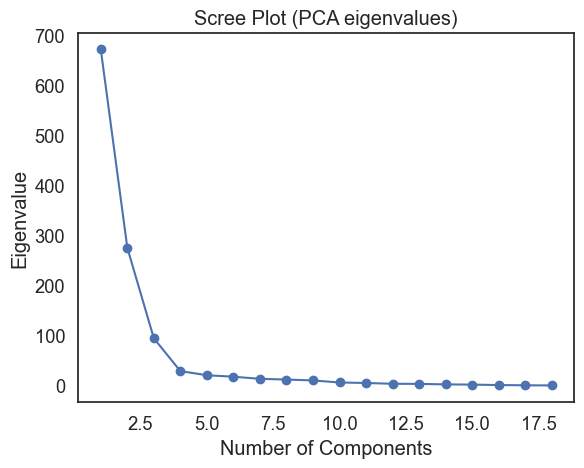

In [79]:
pca = PCA()
pca.fit(X)

# 2) Pull out the eigenvalues
ev = pca.explained_variance_

# 3) Plot the scree
plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.title('Scree Plot (PCA eigenvalues)')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalue')
plt.show()

In [80]:
n_factors = 4
fa = FactorAnalysis(n_components=n_factors, random_state=0)
factor_scores = fa.fit_transform(X)

In [81]:
fa_df = pd.DataFrame(
    factor_scores,
    columns=[f'Factor{i+1}' for i in range(n_factors)],
    index=cc_da.index
)

In [82]:
loadings = pd.DataFrame(
    fa.components_.T,
    index=predictors,
    columns=fa_df.columns
)
print("Factor Loadings:\n", loadings)


Factor Loadings:
                           Factor1    Factor2   Factor3   Factor4
log_mhhi21              -0.132201  -0.099558 -0.076000 -0.142547
cvap21bapp             -10.321919  -0.434027  3.604235 -5.170602
nhw21p                 -14.294088   7.251421 -2.409428 -0.437566
nha21p                   4.433791  -1.649553  4.877725 -0.263228
h21p                     8.983792  -3.957375 -2.647975 -1.094929
white_transplant_ratio  -4.659762  -0.368846  1.544574 -1.916011
greek21p                -1.876256   1.327447 -0.849265  0.443000
arab21p                 -0.133520  -0.215961  0.111859 -0.053095
colomb21p                2.022437  -0.177406  0.000730  0.062220
w2cmp                   -0.849617  -0.246447  1.150011 -0.233298
w2admp                  -2.545323  -1.234858  1.101077 -1.576505
w2hsp                    1.732374  -1.681842  0.434219  0.289692
w2mgtp                  -2.428822   0.022065  0.876503 -0.711932
w2bgp                    1.438913  -0.649393 -0.762011  1.341684
w2lawp 

In [84]:
loadings.to_csv('../data/22_factor_loadings.csv')

In [85]:
fa_df['vote_share'] = cc_da['vote_share']

In [86]:
fa_df.to_csv('../data/22_factor_scores.csv')

In [83]:
Y = cc_da['vote_share']
model_fa = sm.OLS(Y, sm.add_constant(fa_df)).fit()
print(model_fa.summary())

                            OLS Regression Results                            
Dep. Variable:             vote_share   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     34.09
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           4.97e-17
Time:                        11:29:28   Log-Likelihood:                -304.62
No. Observations:                  91   AIC:                             619.2
Df Residuals:                      86   BIC:                             631.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.3764      0.742     61.171      0.0

In [214]:
def rearrange(df,candidates):
    df = df[df['Unit Name'].isin(candidates)]
    df = df[['precinct','ed_name','Unit Name','Tally']]
    df.columns = ['precinct','ed_name','candidate','votes']
    df['ed_total'] = df.groupby('ed_name')['votes'].transform('sum')
    df['vote_share'] = round(df['votes'] / df['ed_total'] * 100,2)
    df['vote_share'] = pd.to_numeric(df['vote_share'], errors='coerce')
    return df


In [211]:
colnames = ['a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'j',
       'k', 
        'AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

good_cols = ['AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

In [212]:
zm = pd.read_csv('../data/mamdani_ass.csv',header=None, names=colnames)
zm = zm[good_cols]

In [213]:
zm['precinct'] = 'AD: ' + zm['AD'].astype(str) + ' ' + 'ED: ' + zm['ED'].astype(str).str.zfill(3)
zm['ed_name'] = zm['AD'].astype(str) + zm['ED'].astype(str).str.zfill(3)

In [217]:
candidates =['Zohran Kwame Mamdani','Aravella Simotas' ]

In [218]:
zm = rearrange(zm,candidates)

In [223]:
zoran = zm[zm['candidate'] == 'Zohran Kwame Mamdani']
zoran.rename(columns={'vote_share':'zoran_vote_share'},inplace=True)
zoran = zoran[['ed_name','zoran_vote_share']]

C:\Users\samtg\AppData\Local\Temp\ipykernel_17040\617319182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zoran.rename(columns={'vote_share':'zoran_vote_share'},inplace=True)


In [224]:
zoran['zoran_standardized'] = (zoran['zoran_vote_share'] - zoran['zoran_vote_share'].mean()) / zoran['zoran_vote_share'].std()

In [226]:
zoran['ed_name'] = zoran['ed_name'].astype('Int64')

In [227]:
cc_da = cc_da.merge(zoran,on='ed_name',how='left')

In [231]:
cor_cols = cc_da[['vote_diff','nhw21p','cvap21bapp','mhhi21','white_transplant_ratio','ind21p','colomb21p',
                  'w2lawp','native_whites','da_standardized','cc_standardized','zoran_standardized']].columns.tolist()
cor_matrix = cc_da[cor_cols].corr()
cor_matrix.sort_values(by='native_whites', ascending=False)

,vote_diff,nhw21p,cvap21bapp,mhhi21,white_transplant_ratio,ind21p,colomb21p,w2lawp,native_whites,da_standardized,cc_standardized,zoran_standardized
native_whites,0.401631,0.946604,0.435909,0.096141,0.383044,-0.697314,-0.543154,0.521008,1.000000,0.301737,-0.032610,-0.304692
nhw21p,0.356092,1.000000,0.653733,0.167328,0.660401,-0.709788,-0.645074,0.441629,0.946604,0.475624,0.178852,-0.105262
w2lawp,0.137418,0.441629,0.079880,-0.229995,0.051844,-0.323186,-0.302292,1.000000,0.521008,-0.174315,-0.288265,-0.377658
cvap21bapp,0.203431,0.653733,1.000000,0.273140,0.857763,-0.411849,-0.579607,0.079880,0.435909,0.719177,0.548916,0.553240
vote_diff,1.000000,0.356092,0.203431,0.063926,0.084812,-0.235520,-0.122100,0.137418,0.401631,0.414364,-0.417566,-0.117070
white_transplant_ratio,0.084812,0.660401,0.857763,0.255497,1.000000,-0.409524,-0.583168,0.051844,0.383044,0.659958,0.588396,0.472238
da_standardized,0.414364,0.475624,0.719177,0.322883,0.659958,-0.304084,-0.346831,-0.174315,0.301737,1.000000,0.653945,0.683972
mhhi21,0.063926,0.167328,0.273140,1.000000,0.255497,-0.069654,-0.132037,-0.229995,0.096141,0.322883,0.269224,0.339403
cc_standardized,-0.417566,0.178852,0.548916,0.269224,0.588396,-0.107815,-0.244776,-0.288265,-0.032610,0.653945,1.000000,0.713278
zoran_standardized,-0.117070,-0.105262,0.553240,0.339403,0.472238,0.169668,0.224589,-0.377658,-0.304692,0.683972,0.713278,1.000000


Finance

In [15]:
by_zip_35 = finance_twenty_two.groupby(['matched_name','ZIP'])['AMNT'].sum().reset_index()
by_zip_35['ZIP'] = by_zip_35['ZIP'].astype(str)

C:\Users\samtg\AppData\Local\Temp\ipykernel_19296\2288632136.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare_nyc['dif'] = compare_nyc['Tiffany Caban'] - compare_nyc['Evie Hantzopoulos']


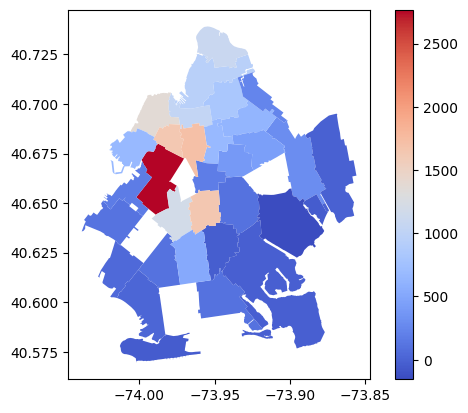

In [17]:
compare = by_zip_35.pivot(index='ZIP',columns='matched_name',values='AMNT').fillna(0).reset_index()
compare_nyc = compare[compare['ZIP'].isin(zip_list)]
compare_nyc['dif'] = compare_nyc['Tiffany Caban'] - compare_nyc['Evie Hantzopoulos']
zip_map = compare_nyc.merge(nyc_zip, left_on='ZIP', right_on='zcta', how='left')
zip_map = gpd.GeoDataFrame(zip_map)

brooklyn_map = zip_map[zip_map['ZIP'].isin(brooklyn_zips)]
brooklyn_map.plot(column='dif', cmap='coolwarm', legend=True)
plt.show()